In [2142]:
import numpy as np
def gen_data(mu, delta, n, d: int = 2):
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    mu = np.full((n, d), mu, dtype=np.float64)

    if len(delta) == 1 and delta[0] == 0:
        return mu + noise, np.zeros(n)
    
    # 10% of the data are abnormal
    m = len(delta)
    abnormal_idx = np.random.choice(n, int(n/10), replace=False)

    ptr = 0
    for i in range(m):
        for j in range(len(abnormal_idx)//m):
            mu[abnormal_idx[ptr], :] += delta[i]
            ptr += 1
    
    X = mu + noise 
    Y = np.zeros(n)
    Y[abnormal_idx] = 1
    return X, Y

In [2143]:
import torch
import torch.nn as nn
from typing import List
class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32, 16, 8, 4, 2], critic_hidden_dims: List[int]=[32, 16, 8, 4, 2],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        """Compute gradient penalty."""
        if source_data.size(0) > target_data.size(0):
            ms = source_data.size(0)
            mt = target_data.size(0)
            gradient_penalty = 0
            for _ in range(0, ms, mt):
                source_chunk = source_data[_:_+mt]
                target_chunk = target_data
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            if ms % mt != 0:
                source_chunk = source_data[ms-mt:]
                perm = torch.randperm(mt)
                idx = perm[:ms % mt]
                target_chunk = target_data[idx]
                alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
                interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
                # Domain critic outputs
                dc_output = self.critic(interpolates)
                
                # Compute gradients
                gradients = torch.autograd.grad(
                    outputs=dc_output,
                    inputs=interpolates,
                    grad_outputs=torch.ones_like(dc_output).to(self.device),
                    create_graph=True,
                    retain_graph=True,
                    only_inputs=True,
                )
                gradients = gradients[0]
                gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            return gradient_penalty / ((ms // mt) + (ms % mt != 0)) 
        
        # For balanced batch
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
        # Domain critic outputs
        dc_output = self.critic(interpolates)
        
        # Compute gradients
        gradients = torch.autograd.grad(
            outputs=dc_output,
            inputs=interpolates,
            grad_outputs=torch.ones_like(dc_output).to(self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # Compute gradient penalty
        gradients = gradients.view(gradients.size(0), -1)
        return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data)
                        target_features = self.generator(target_data)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = dc_source.mean() - dc_target.mean()

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    dc_loss.backward()
                    self.critic_optimizer.step()

                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = dc_source.mean() - dc_target.mean()
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {wasserstein_distance.item()}')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [2144]:
# Create a new instance of the WDGRL model (same architecture as before)
model = WDGRL(input_dim=1,generator_hidden_dims=[10, 10, 10, 10], critic_hidden_dims=[10])

# Load the saved checkpoint
checkpoint = torch.load("wdgrl.pth", map_location=model.device, weights_only=True)

# Restore the model weights
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.critic.load_state_dict(checkpoint['critic_state_dict'])

print("Model loaded successfully!")

Model loaded successfully!


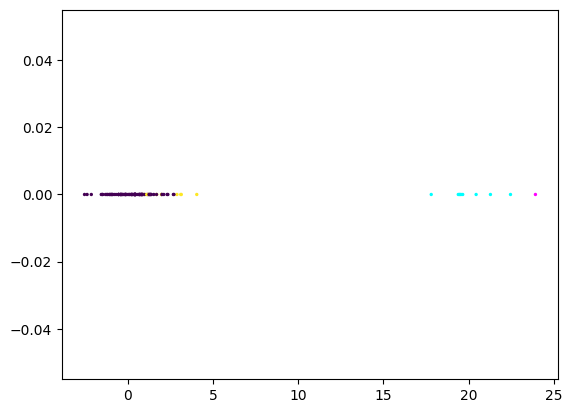

In [2145]:
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 100, 10, 1
mu_s, mu_t = 0, 20
delta_s, delta_t = [1, 2, 3, 4], [4]
xs, ys = gen_data(mu_s, delta_s, ns, d)
xt, yt = gen_data(mu_t, delta_t, nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [2146]:
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())

In [2147]:
def max_sum(X):
    return np.argmax(np.sum(X, axis=1))
x_hat = torch.cat([xs_hat, xt_hat], dim=0).cpu().numpy()
print(x_hat)
O = max_sum(x_hat)
O = [O-ns]
O

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[0]

In [2148]:
yt_hat = torch.zeros_like(yt)
yt_hat[O[0]] = 1
print(yt)
yt_hat

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000


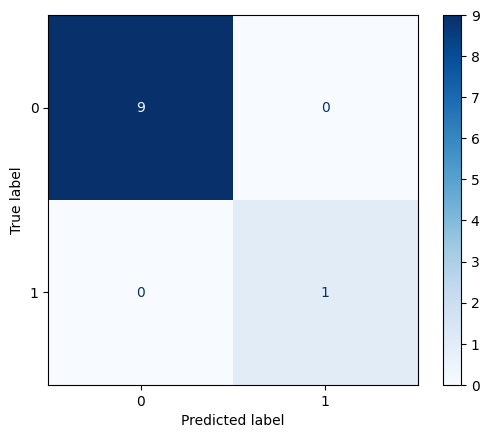

In [2149]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(yt, yt_hat)
precision = precision_score(yt, yt_hat)
recall = recall_score(yt, yt_hat)
f1 = f1_score(yt, yt_hat)

# Print classification report
print(classification_report(yt, yt_hat))

# Print the scores
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(yt, yt_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)  
plt.show()

In [2150]:
from mpmath import mp

mp.dps = 500
def intersect(itv1, itv2):
    # print(itv1, itv2)
    itv = [max(itv1[0], itv2[0]), min(itv1[1], itv2[1])]
    if itv[0] > itv[1]:
        return None    
    return itv

def solve_linear_inequality(u, v): #u + vz < 0
    u = float(u)
    v = float(v)
    if (v > -1e-16 and v < 1e-16):
        if (u < 0):
            return [-np.Inf, np.Inf]
        else:
            print('error')
            return None
    if (v < 0):
        return [-u/v, np.Inf]
    return [np.NINF, -u/v]

def get_dnn_interval(Xtj, a, b):
    layers = []

    for name, param in model.generator.named_children():
        temp = dict(param._modules)
        
        for layer_name in temp.values():
            if ('Linear' in str(layer_name)):
                layers.append('Linear')
            elif ('ReLU' in str(layer_name)):
                layers.append('ReLU')

    ptr = 0
    itv = [np.NINF, np.Inf]
    u = a
    v = b
    temp = Xtj
    weight = None
    bias = None
    for name, param in model.generator.named_parameters():
        if (layers[ptr] == 'Linear'):
            if ('weight' in name):
                weight = param.data.cpu().detach().numpy()
            elif ('bias' in name):
                bias = param.data.cpu().detach().numpy().reshape(-1, 1)
                ptr += 1
                temp = weight.dot(temp) + bias
                u = weight.dot(u) + bias
                v = weight.dot(v)

        if (ptr < len(layers) and layers[ptr] == 'ReLU'):
            ptr += 1
            Relu_matrix = np.zeros((temp.shape[0], temp.shape[0]))
            sub_itv = [np.NINF, np.inf]
            for i in range(temp.shape[0]):
                if temp[i] > 0:
                    Relu_matrix[i][i] = 1
                    sub_itv = intersect(sub_itv, solve_linear_inequality(-u[i], -v[i]))
                else:
                    sub_itv = intersect(sub_itv, solve_linear_inequality(u[i], v[i]))
            itv = intersect(itv, sub_itv)
            temp = Relu_matrix.dot(temp)
            u = Relu_matrix.dot(u)
            v = Relu_matrix.dot(v)

    return itv, u, v

def get_ad_interval(X, X_hat, O, a, b):
    itv = [np.NINF, np.Inf]
    for i in range(X.shape[0]):
        itv = intersect(itv, get_dnn_interval(X[i].reshape(-1, 1), a[i].reshape(-1, 1), b[i].reshape(-1, 1))[0])
    _, uo, vo = get_dnn_interval(X[O].reshape(-1, 1), a[O].reshape(-1, 1), b[O].reshape(-1, 1))
    I = np.ones((X_hat.shape[1],1))
    sub_itv = [np.NINF, np.inf]
    for i in range(X.shape[0]):
        if (i != O):
            _, ui, vi = get_dnn_interval(X[i].reshape(-1, 1), a[i].reshape(-1, 1), b[i].reshape(-1, 1))
            u = uo - ui
            v = vo - vi 
            u = I.T.dot(u)
            v = I.T.dot(v)
            sub_itv = intersect(sub_itv, solve_linear_inequality(-u, -v))
    itv = intersect(itv, sub_itv)
    return itv

def compute_yz(X, etaj, zk, n):
    sq_norm = (np.linalg.norm(etaj))**2

    e1 = np.identity(n) - (np.dot(etaj, etaj.T))/sq_norm
    a = np.dot(e1, X)

    b = etaj/sq_norm

    Xz = a + b*zk

    return Xz, a, b

def parametric_wdgrl(Xz, a, b, n, zk):
    Xz = torch.FloatTensor(Xz)
    Xz_hat = model.extract_feature(Xz.cuda())
    Oz = [max_sum(Xz_hat.cpu().numpy())]
    itv = get_ad_interval(Xz, Xz_hat, Oz[0], a, b)
    return itv[1] - min(zk, itv[1]), Oz


def run_parametric_wdgrl(X, etaj, n, threshold):
    zk = -threshold

    list_zk = [zk]
    list_Oz = []

    while zk < threshold:
        Xz, a, b = compute_yz(X, etaj, zk, n)
        skz, Oz = parametric_wdgrl(Xz, a, b, n, zk)

        zk = zk + skz + 1e-6 
        if zk < threshold:
            list_zk.append(zk)
        else:
            list_zk.append(threshold)
        list_Oz.append(Oz)
        # print(f'intervals: {zk-skz-1e-6} - {zk -1e-6}')
        # print(f'Anomaly index: {Oz}')
    return list_zk, list_Oz
        
def cdf(mu, sigma, list_zk, list_Oz, etajTX, O):
    numerator = 0
    denominator = 0
    for each_interval in range(len(list_zk) - 1):
        al = list_zk[each_interval]
        ar = list_zk[each_interval + 1] - 1e-6

        if (np.array_equal(O, list_Oz[each_interval]) == False):
            continue

        denominator = denominator + mp.ncdf((ar - mu)/sigma) - mp.ncdf((al - mu)/sigma)
        if etajTX >= ar:
            numerator = numerator + mp.ncdf((ar - mu)/sigma) - mp.ncdf((al - mu)/sigma)
        elif (etajTX >= al) and (etajTX< ar):
            numerator = numerator + mp.ncdf((etajTX - mu)/sigma) - mp.ncdf((al - mu)/sigma)

    if denominator != 0:
        return float(numerator/denominator)
    else:
        return None

def run_fpr():
    # np.random.seed(42)
    ns, nt, d = 100, 10, 1
    mu_s, mu_t = 0, 20
    delta_s, delta_t = [4], [0]
    xs, ys = gen_data(mu_s, delta_s, ns, d)
    xt, yt = gen_data(mu_s, delta_t, nt, d)

    xs = torch.FloatTensor(xs)
    ys = torch.LongTensor(ys)
    xt = torch.FloatTensor(xt)
    yt = torch.LongTensor(yt)

    xs = xs.cuda()
    xt = xt.cuda()
    ys = ys.cuda()
    yt = yt.cuda()

    xs_hat = model.extract_feature(xs)
    xt_hat = model.extract_feature(xt)
    x_hat = torch.cat([xs_hat, xt_hat], dim=0)

    xs_hat = xs_hat.cpu()
    xt_hat = xt_hat.cpu()
    x_hat = x_hat.cpu()
    xs = xs.cpu()
    xt = xt.cpu()
    ys = ys.cpu()
    yt = yt.cpu()

    O = max_sum(x_hat.numpy())
    if (O < 100):
        return None
    else:
        O = [O - 100]   
    Oc = list(torch.where(yt == 0)[0])
    X = np.vstack((xs, xt))
    X = torch.FloatTensor(X)
    j = np.random.choice(O)
    etj = np.zeros((nt, 1))
    etj[j][0] = 1
    etOc = np.zeros((nt, 1))
    etOc[Oc] = 1
    etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))

    etajTx = etaj.T.dot(X)
    
    print(f'Anomaly index: {O[0] + 100}')
    print(f'etajTX: {etajTx}')
    mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
    sigma = np.identity(ns+nt)
    etajTmu = etaj.T.dot(mu)
    etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
    b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
    a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)
    threshold = 20
    list_zk, list_Oz = run_parametric_wdgrl(X, etaj, ns+nt, threshold)
    CDF = cdf(etajTmu[0][0], etajTsigmaetaj[0][0], list_zk, list_Oz, etajTx[0][0], [O[0] + 100])
    p_value = 2 * min(CDF, 1 - CDF)
    print(f'p-value: {p_value}')
    print('-------------------------------------------------')
    return p_value
    


In [2151]:
import scipy.stats as stats
max_iteration = 1000
alpha = 0.05
list_p_value = []
count = 0
print(f'iteration #{0}:')


while len(list_p_value) < max_iteration:
    p_value = run_fpr()
    if p_value is None:
        continue
    print(f'iteration #{len(list_p_value)+1}:')
    list_p_value.append(p_value)
    if p_value <= alpha:
        count += 1
print(f'FPR: {count / len(list_p_value)}')
print(f'KS-test p-value: {stats.kstest(list_p_value, 'uniform')[1]}')


plt.hist(list_p_value)
plt.show()

iteration #0:


KeyboardInterrupt: 

In [2152]:
def run_tpr():
    # np.random.seed(42)
    # Create datasets
    ns, nt, d = 100, 10, 1
    mu_s, mu_t = 0, 2
    delta_s, delta_t = [1, 2, 3,4], [4]
    xs, ys = gen_data(mu_s, delta_s, ns, d)
    xt, yt = gen_data(mu_t, delta_t, nt, d)

    xs = torch.FloatTensor(xs)
    ys = torch.LongTensor(ys)
    xt = torch.FloatTensor(xt)
    yt = torch.LongTensor(yt)

    xs = xs.cuda()
    xt = xt.cuda()
    ys = ys.cuda()
    yt = yt.cuda()

    xs_hat = model.extract_feature(xs)
    xt_hat = model.extract_feature(xt)
    x_hat = torch.cat([xs_hat, xt_hat], dim=0)

    xs_hat = xs_hat.cpu()
    xt_hat = xt_hat.cpu()
    x_hat = x_hat.cpu()
    xs = xs.cpu()
    xt = xt.cpu()
    ys = ys.cpu()
    yt = yt.cpu()

    O = max_sum(x_hat.numpy())
    if (O < ns):
        return None
    else:
        O = [O - ns]   
    if yt[O[0]] == 0:
        return None
    Oc = list(torch.where(yt == 0)[0])
    X = np.vstack((xs, xt))
    X = torch.FloatTensor(X)
    j = np.random.choice(O)
    etj = np.zeros((nt, 1))
    etj[j][0] = 1
    etOc = np.zeros((nt, 1))
    etOc[Oc] = 1
    etaj = np.vstack((np.zeros((ns, 1)), etj-(1/len(Oc))*etOc))

    etajTx = etaj.T.dot(X)
    
    print(f'Anomaly index: {O[0] + ns}')
    print(f'etajTX: {etajTx}')
    mu = np.vstack((np.full((ns,1), mu_s), np.full((nt,1), mu_t)))
    sigma = np.identity(ns+nt)
    etajTmu = etaj.T.dot(mu)
    etajTsigmaetaj = etaj.T.dot(sigma).dot(etaj)
    b = sigma.dot(etaj).dot(np.linalg.inv(etajTsigmaetaj))
    a = (np.identity(ns+nt) - b.dot(etaj.T)).dot(X)
    threshold = 20
    list_zk, list_Oz = run_parametric_wdgrl(X, etaj, ns+nt, threshold)
    CDF = cdf(etajTmu[0][0], etajTsigmaetaj[0][0], list_zk, list_Oz, etajTx[0][0], [O[0] + ns])
    p_value = 2 * min(CDF, 1 - CDF)
    print(f'p-value: {p_value}')
    print('-------------------------------------------------')
    return p_value

iteration #0:
Anomaly index: 107
etajTX: [[3.31410458]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_22296\2610257826.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(u)
C:\Users\Admin\AppData\Local\Temp\ipykernel_22296\2610257826.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(v)


p-value: 0.7567371453392275
-------------------------------------------------
iteration #1:
Anomaly index: 107
etajTX: [[3.20405869]]
p-value: 0.8859762085548786
-------------------------------------------------
iteration #2:
Anomaly index: 107
etajTX: [[3.34925913]]
p-value: 0.04049195150750706
-------------------------------------------------
iteration #3:
Anomaly index: 102
etajTX: [[5.34805247]]
p-value: 8.105448723183528e-05
-------------------------------------------------
iteration #4:
Anomaly index: 108
etajTX: [[5.12805402]]
p-value: 0.0001646541569233495
-------------------------------------------------
iteration #5:
Anomaly index: 101
etajTX: [[3.31604115]]
p-value: 0.044897989969270746
-------------------------------------------------
iteration #6:
Anomaly index: 104
etajTX: [[3.86723504]]
p-value: 0.03897216754626531
-------------------------------------------------
iteration #7:
Anomaly index: 106
etajTX: [[4.35843623]]
p-value: 0.0009091146503623637
---------------------

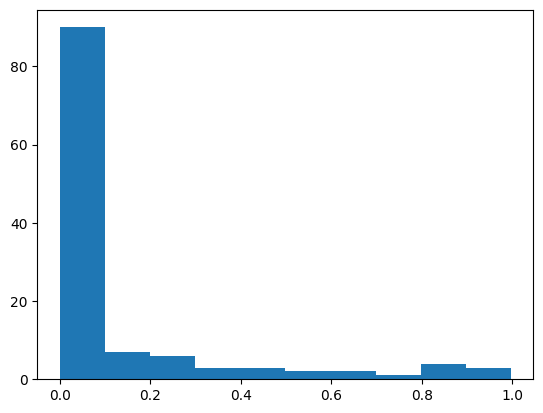

In [2153]:
import scipy.stats as stats
max_iteration = 120
alpha = 0.05
list_p_value = []
count = 0
print(f'iteration #{0}:')


while len(list_p_value) <= max_iteration:
    p_value = run_tpr()
    if p_value is None:
        continue
    print(f'iteration #{len(list_p_value)+1}:')
    list_p_value.append(p_value)
    if p_value <= alpha:
        count += 1
print(f'TPR: {count / len(list_p_value)}')
plt.hist(list_p_value)
plt.show()